# Testing Accuracy of PAZ and DeepFace
**Author:** Niklas Bockholt  
**License:** MIT License  

In [12]:
import numpy as np
from PIL import Image
from numpy import asarray
from paz.pipelines import MiniXceptionFER
from paz.backend.image import show_image
import deepface

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os

## Some Playing Around

In [14]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

image = Image.open("./data/images/4/Happy.jpg")
#image.show()
numpy_image = asarray(image)

classify = MiniXceptionFER()
predictions = classify(numpy_image)

scores = predictions["scores"].flatten()

for emotion, score in zip(emotions, scores):
    print(f"{emotion}: {score:.4f}")

from paz.applications import HaarCascadeFrontalFace, MiniXceptionFER
import paz.processors as pr

class EmotionDetector(pr.Processor):
    def __init__(self):
        super(EmotionDetector, self).__init__()
        self.detect = HaarCascadeFrontalFace(draw=False)
        self.crop = pr.CropBoxes2D()
        self.classify = MiniXceptionFER()
        self.draw = pr.DrawBoxes2D(self.classify.class_names)

    def call(self, image):
        boxes2D = self.detect(image)['boxes2D']
        cropped_images = self.crop(image, boxes2D)
        for cropped_image, box2D in zip(cropped_images, boxes2D):
            box2D.class_name = self.classify(cropped_image)['class_name']
        return self.draw(image, boxes2D)
    
detect = EmotionDetector()

predictions = detect(numpy_image.copy())

# Image.fromarray(predictions).show()

angry: 0.1127
disgust: 0.0130
fear: 0.0243
happy: 0.6239
sad: 0.0582
surprise: 0.0278
neutral: 0.1401


## PAZ and DeepFace Performance on Test Set

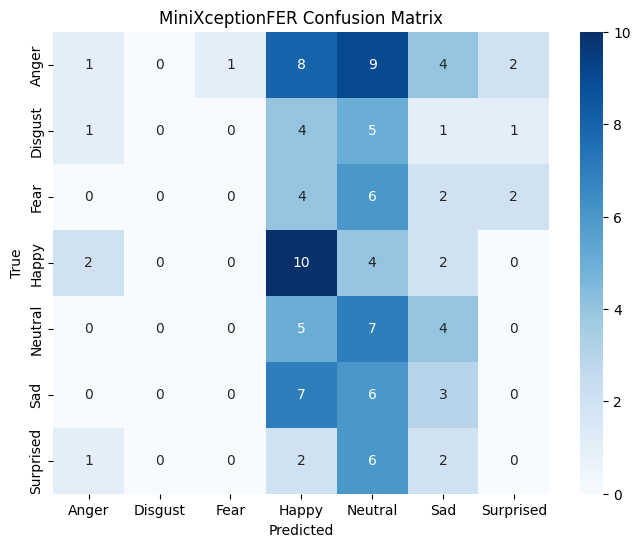

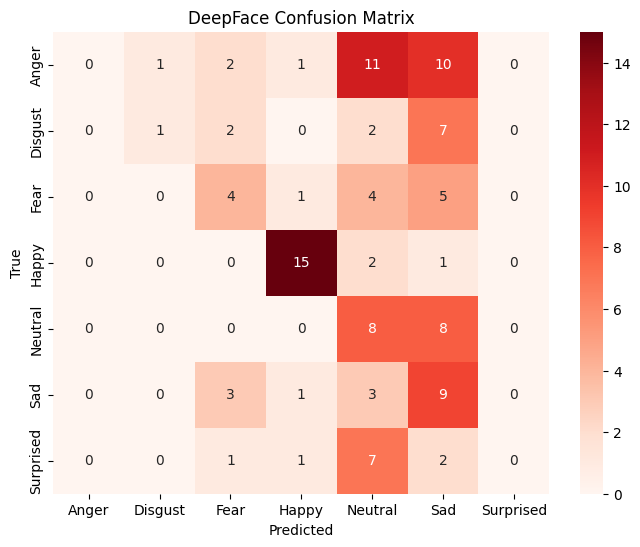


MiniXceptionFER Classification Report:
               precision    recall  f1-score   support

       Anger       0.20      0.04      0.07        25
     Disgust       0.00      0.00      0.00        12
        Fear       0.00      0.00      0.00        14
       Happy       0.25      0.56      0.34        18
     Neutral       0.16      0.44      0.24        16
         Sad       0.17      0.19      0.18        16
   Surprised       0.00      0.00      0.00        11

    accuracy                           0.19       112
   macro avg       0.11      0.17      0.12       112
weighted avg       0.13      0.19      0.13       112


DeepFace Classification Report:
               precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        25
     Disgust       0.50      0.08      0.14        12
        Fear       0.33      0.29      0.31        14
       Happy       0.79      0.83      0.81        18
     Neutral       0.22      0.50      0.30        16
   

In [ ]:
classifier = MiniXceptionFER()

# Define dataset emotions (used in filenames) and PAZ's class order
dataset_emotions = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']
paz_emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Mapping PAZ output -> dataset format
paz_to_dataset = {
    "angry": "Anger",
    "disgust": "Disgust",
    "fear": "Fear",
    "happy": "Happy",
    "sad": "Sad",
    "surprise": "Surprised",
    "neutral": "Neutral"
}

# Merge "Contempt" with "Anger"
mapped_emotions = {'Contempt': 'Anger'}
final_emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']  # Only 7 classes now

# Ground truth & predictions
true_labels = []
paz_predictions = []
deepface_predictions = []

for i in range(1, 19): 
    for emotion in dataset_emotions:
        image_path = f"./data/images/{i}/{emotion}.jpg"
        if not os.path.exists(image_path):
            print(f"Warning: {image_path} not found!")
            continue

        image = Image.open(image_path).convert("RGB")
        image_np = np.asarray(image)

        # PAZ
        paz_result = classifier(image_np)
        paz_index = np.argmax(paz_result["scores"])
        paz_emotion = paz_emotions[paz_index]
        paz_emotion = paz_to_dataset.get(paz_emotion, paz_emotion) 

        # DeepFace 
        try:
            deepface_result = DeepFace.analyze(image_np, actions=['emotion'], enforce_detection=False)
            deepface_emotion = deepface_result[0]['dominant_emotion'].capitalize()
        except Exception as e:
            deepface_emotion = "Error"

        # Map Contempt to Anger
        true_emotion = mapped_emotions.get(emotion, emotion)

        # Store results as indices
        if deepface_emotion in final_emotions:  # Ensure DeepFace emotion exists in our classes
            true_labels.append(final_emotions.index(true_emotion))
            paz_predictions.append(final_emotions.index(paz_emotion))
            deepface_predictions.append(final_emotions.index(deepface_emotion))

# Compute and plot PAZ Confusion Matrix
paz_cm = confusion_matrix(true_labels, paz_predictions, labels=range(len(final_emotions)))
plt.figure(figsize=(8, 6))
sns.heatmap(paz_cm, annot=True, fmt='d', xticklabels=final_emotions, yticklabels=final_emotions, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MiniXceptionFER Confusion Matrix")
plt.show()

# Compute and plot DeepFace Confusion Matrix
deepface_cm = confusion_matrix(true_labels, deepface_predictions, labels=range(len(final_emotions)))
plt.figure(figsize=(8, 6))
sns.heatmap(deepface_cm, annot=True, fmt='d', xticklabels=final_emotions, yticklabels=final_emotions, cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DeepFace Confusion Matrix")
plt.show()

# Print Classification Reports
print("\nMiniXceptionFER Classification Report:\n", classification_report(true_labels, paz_predictions, target_names=final_emotions, zero_division=0))
print("\nDeepFace Classification Report:\n", classification_report(true_labels, deepface_predictions, target_names=final_emotions, zero_division=0))
